<a href="https://colab.research.google.com/github/alirempel/cap-comp215/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project 2: Deer Park Model**
###**Author: Alison Rempel**
###**Date: 2024-04-09**

### This model simulates a grassy environment where deer roam and graze.

### The deer move randomly and graze at each cell they go to, making the cell empty. Deer gain weight when they find grass and lose weight if they do not. A deer has a maxium weight and cannot exceed that and if a deer's weight hits zero it will die and disappear from the simulation.

### Grass regenerates at each time step with a probability *p* and the environment starts with a proportion of grass with probability *q*.

---



Below are the imported modules:

In [1]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
import random
import itertools

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

## This is reused code for animating a simulation model:

In [2]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass


### ***Note:** A lot of the code for the Deer and Environment classes was repurposed from the week 12 lesson on 'agents'.

## **Deer Class:**
Creates a Deer object and controls the actions of said deer and its interactions with the environment such as:
* deer factory for creating multiple deer with random locations,
* finds the neighbouring cells of the deer,
* randomly picks an empty cell (no deer) for the deer's next step,
* performs each deer's 'step' (move location to next cell, graze, gain/lose weight, and check if deer has starved)

In [4]:
def make_locations(n, m):
    """ Return list of (x, y) coordinates for all locations on n x m grid """
    return list(itertools.product(range(n), range(m)))

In [5]:
class Deer:
    """ Represent one deer object """

    # constant values
    max_weight=50
    initial_weight=20
    weight_gain=1
    weight_loss=1

    def __init__(self, loc=(0,0)):
        """Creates a new deer at the given location.

        loc: (x,y) tuple coordinate
        weight: int between 0 and 50
        """
        self.loc = tuple(loc)
        self.weight = self.initial_weight

    @classmethod
    def make_deer(cls, num_deer, n):
        """ Factory: return a list Deer objects at random locations in n x m grid """
        # all (x,y) locations in an n x n grid...
        locations = make_locations(n, n)
        assert num_deer <= len(locations)  # verify pre-condition: there are enough locations for all deer
        # randomize the locations and construct the desired number of deer at random locations
        np.random.shuffle(locations)
        return [cls(locations[i]) for i in range(num_deer)]

    def visible_locations(self,x,y):
        """Return a list of (x,y) cell coordinates that are "visible" to the deer """
        neighbours = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        return neighbours

    def next_cell(self, env):
        """Picks neighbouring cell without deer.

        env: the grass area the deer lives in
        returns: tuple, coordinates of random neighbouring cell without deer
        """
        # find all empty, visible cells, "wrapping" vision around edges of environment
        visible_locs = env.wrap_locations( self.visible_locations(*self.loc) )
        empty_locs = env.get_empty_locations(visible_locs)
        if len(empty_locs) == 0:
          return self.loc

        return random.choices(empty_locs)[0]

    def step(self, env):
        """Look around, move, and graze.

        env: Environment object
        """
        self.loc = self.next_cell(env)

        if env.state[self.loc]==env.OCCUPIED:
            self.weight += self.weight_gain
            env.graze(self.loc)
        else:
            self.weight -= self.weight_loss

    def is_starving(self):
        """Checks if weight has gone below 0."""
        return self.weight <= 0

## **Environment Class:**
2D cellular automata grid that controls the actions of the environment such as:
* grazing (occupied cells going to empty cells),
* grass growth (empty cells going to occupied cells),
* keeping track of where the deer are (get_empty_locations method),
* running each deer's step function,
* creating a draw method for the grid along with the deer, for use with the Animation2D class.

In [6]:
class Environment:
    """Represents an environment with grazing deer."""

    EMPTY = 0
    OCCUPIED = 1

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    env_colour_map = matplotlib.colors.ListedColormap(cmap)

    def __init__(self, n, deers, p=.01,q=.5):
        """Initializes the attributes.

        n: number of rows and columns
        deers: iterable of deer, with random locations on (n, n) (used 'deers' because I needed some way to represent more than one deer)
        p: probability empty cell grows grass
        q: initial grass density (probability cell has grass (is occupied) in initial state)
        """
        assert(len(deers) <= n**2)  # can't have more deer than there are grid cells

        self.n = n
        self.deers = deers
        self.p = p
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        # keep track of which cells are unoccupied
        self.unoccupied = set(make_locations(n, n)) - set(deer.loc for deer in self.deers)


    def wrap_locations(self, locations):
        """ return listt of (x,y) locations, where each location is "wrapped" so it falls within the grid

        locations: iterable of 2-tuple (x,y) locations, some of which may fall outside grid dimensions
        """
        return [(x%self.n, y%self.n) for x,y in locations]

    def get_empty_locations(self, locations):
        """ select and return list locations that are unoccupied """
        return [loc for loc in locations if loc in self.unoccupied]

    def grow(self):
        """ grow grass in cells"""
        self.state[self.state == self.EMPTY] = np.random.choice([self.OCCUPIED,self.EMPTY], len(self.state[self.state==self.EMPTY]), 1, (self.p, 1-self.p))

    def graze(self, loc):
        """ remove grass from the given location """
        self.state[loc] = self.EMPTY

    def deer_population(self):
      """ return deer population """
      return len(self.deers)

    def step(self):
        """ Execute one time step. """
        # grow back some grass
        self.grow()
        # loop through the deers in random order
        for deer in np.random.permutation(self.deers):
            # mark the deer's cell unoccupied and allow them to "step" to new location
            self.unoccupied.add(deer.loc)
            deer.step(self)

            # if the deer is dead, remove from model
            if deer.is_starving():
                self.deers.remove(deer)
            else:
                # otherwise mark its new cell as occupied
                self.unoccupied.remove(deer.loc)

        return len(self.deers)

    def draw(self, axes=None, step=''):
        """Draws the environment with deer"""
        axes = axes or plt.gca()
        title = f'Time:{step} Deer population: {self.deer_population()}'
        plot_2d_array(self.state, axes=axes, title=title, cmap=self.env_colour_map, vmin=0, vmax=len(self.env_colour_map.colors))
        if self.deers:
            self._draw_deers()

    def _draw_deers(self):
        """ Draw the deers in centre of cell they occupy """
        # Transform from (col, row) to centre (x, y) of cell coordinate.
        rows, cols = np.transpose([deer.loc for deer in self.deers])
        xs = cols
        ys = rows
        plt.plot(xs, ys, '.', color='brown',markersize=400//self.n) # make deer a good size relative to size of grid


## **Customizable parameters for the animation:**
*   p1 = probability of grass regrowth (float < 1)
*   q1 = initial probability of grass cells in environment (float < 1)
*   n1 = amount of rows and columns in grid (int)
*   n_deer = amount of deer at the start of the simulation (int < n1^2)
*   time_steps = amount of frames in the animation (int)

In [7]:
p1 = .3
q1 = .5
n1 = 10
n_deer = 30
time_steps1 = 50

Code to run the animation:

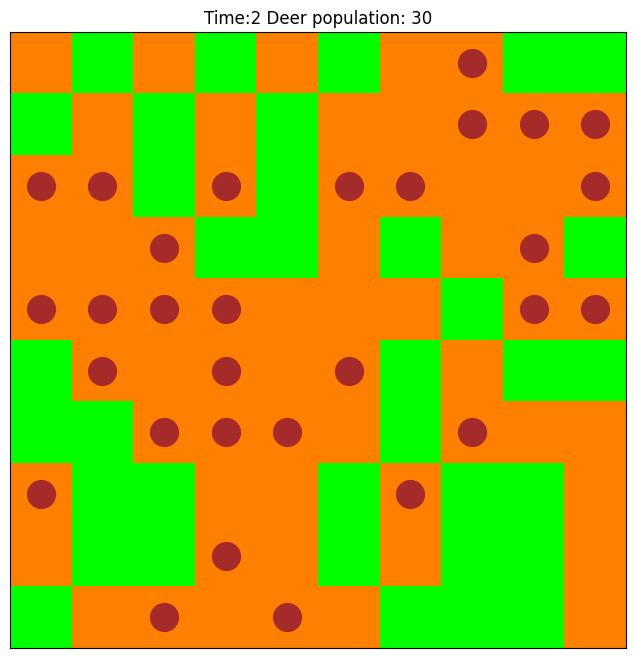

In [15]:
deer_list = Deer.make_deer(num_deer=n_deer,n=n1)
deer_model = Environment(n=n1,deers=deer_list,p=p1,q=q1)
deer_animation = Animation2D(deer_model,frames=time_steps1)
deer_animation.animate(interval=.5)

## **Experiments:**
The goal was to try and find a how certain values determine the likelyhood that a deer population will survive long term. The controlled variables for both experiments are the size of the grid (n2) and the amount of steps each simulation will run (time_steps2).

In [8]:
time_steps2 = 500
n2 = 30

This will compute the percent of deer surviving after the given time steps. It is used to compute the y-values for each experiments graph.

In [10]:
def find_surviving_deer(model,deer_pop):
  ''' This function returns the percentage of deer that survive out of the original population after "time_steps2" number of steps
  model: takes an Environment object
  deer_pop: optional- takes the current start population of deer (for experiment 1 where it flucuates)'''

  for step in range(time_steps2):
    model.step()
    if model.deer_population() == 0:
      return 0
  return round(model.deer_population()/deer_pop,2)*100

### **Experiment 1:**
Including the previous controlled variables, this experiment also controls the p value (*p_value*). The purpose is to see what effect the starting deer population has on the survival rate of the deer long term. It runs the simulation for the set number of time steps over a range of deer populations (*deer_range*) and graphs the results.

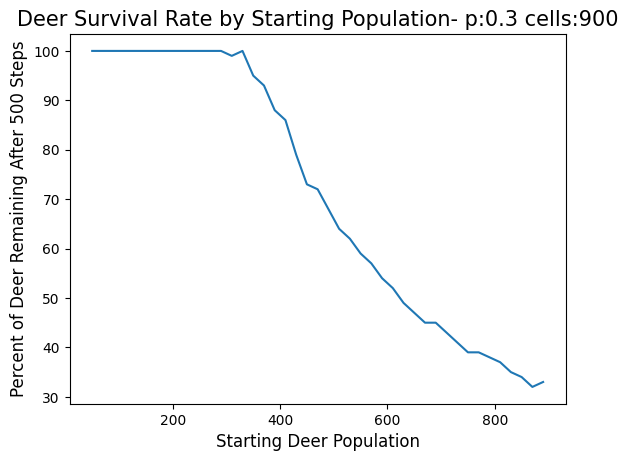

In [19]:
p_value = .3
deer_populations = range(50,900,20)

def experiment1(deer_range,p):
  ''' Loop through the range of deer populations given (deer_range) and run the model with that many deer and a constant p value (p) 'time_steps2' times
  and then use find_surviving_deer on each run.
  This calculates the y values (deer_survival_values) for the graph.
  The given range of deer_range is the x values. '''

  deer_survival_values = []

  for num_deers in deer_range:
    deers = Deer.make_deer(num_deer=num_deers,n=n2)
    model = Environment(n=n2,deers=deers,p=p)
    deer_survival_values.append(find_surviving_deer(model,deer_pop=num_deers))


  plt.plot(deer_range, deer_survival_values)
  plt.xlabel("Starting Deer Population", size=12)
  plt.ylabel(f"Percent of Deer Remaining After {time_steps2} Steps", size=12)
  plt.title(f"Deer Survival Rate by Starting Population- p:{p} cells:{n2**2}", size=15)
  plt.show()


experiment1(deer_populations,p_value)


### Results:
When the deer population is low it plateaus at 100% survival, then exponentially decreases until it hits where the starting deer population = the number of cells. If the *p* value is higher, the curve gets "pushed over"- the 100% survival rate increases and then the decline starts much later.

This graph can be used to find what the highest population of deer you can have with the given *p* value, where the population remains stable.

With the current *p* (p=0.3) shown on the graph above, if you want a stable population where 100% of the deer last long term, you can only start with 350~ deer or less.

### **Experiment 2:**
Including the previous controlled variables, this experiment also controls the deer population (*num_deer*). The purpose of this experiment is to see what effect the *p* value has on the long term survival rate of the deer population. It runs the simulation for the set number of time steps over a range of p values (*p_values*) and graphs the results.

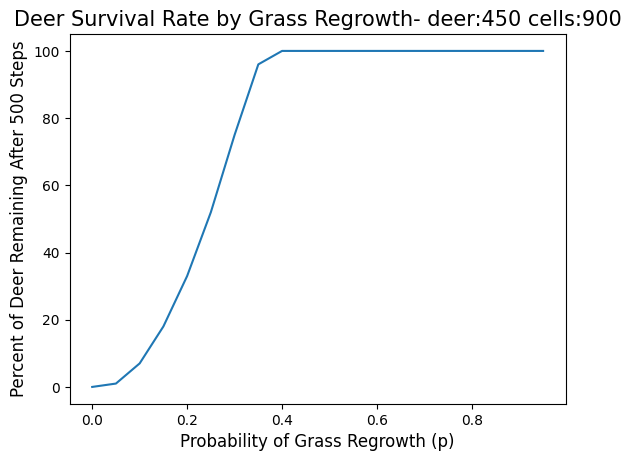

In [11]:

num_deer= n2**2//2
p_values = np.arange(0.0, 1, 0.05)


def experiment2(n_deer,ps):
  ''' Loop through the range of ps given (ps) and run the model with that p value and a constant number of deer (n_deer) 'time_steps2' times
  and then use find_surviving_deer on each run.
  This calculates the y values (deer_survival_values) for the graph.
  The given range of deer_range is the x values. '''


  deer_survival_values = []

  for p in ps:
    deers = Deer.make_deer(num_deer=n_deer, n=n2)
    model = Environment(n=n2, deers=deers, p=p)
    deer_survival_values.append(find_surviving_deer(model,deer_pop = n_deer))


  plt.plot(ps, deer_survival_values)
  plt.xlabel("Probability of Grass Regrowth (p)", size=12)
  plt.ylabel(f"Percent of Deer Remaining After {time_steps2} Steps", size=12)
  plt.title(f"Deer Survival Rate by Grass Regrowth- deer:{n_deer} cells:{n2**2}", size=15)
  plt.show()

experiment2(num_deer,p_values)

### Results:
When the *p* is low, the survival rate starts at 0%, then exponentially increases until it hits where the survival rate plateaus at 100%. If the deer population is higher, the 100% survival rate plateau gets shorter, and the curve from 0% to 100% is less steep.

Similar to the other graph, this can be used to find where the population remains stable after the given time steps. It shows the lowest *p* value you can have with the given deer population, where the population doesn't die off.

With the current deer population, (450 or 1/2 of the number of cells) shown on the graph above, if you want a stable population where 100% of the deer last long term, your *p* must be higher than 0.4.

## **Overall Results:**
While this model is much simpler than a real ecosystem, it does show some similar behaivours. It demonstrates how populations need to be below a certain density or the species will die out, and how the environment needs to provide resources fast enough for the population it sustains.

If I had more time, I would try to implement a way for deer to be born and die, because that would make the population survival rates more realistic. Also a way for deer to age, because I think immortal deer also skews results a bit.

## **Timing Tests:**
I believe that the runtime of the Environment model's step function is ***D*** x ***S*** where ***D*** is the number of deer and ***S*** is the number of steps.

The program only loops through the cells once, so that would be ***N*** times for a ***N*** x ***N*** grid when it creates the model. However, during the 'step' method, it never loops through the entire grid again, it only looks at each deer's immediate neighbours. So ***N*** doesn't effect the speed outside of creating the model.

However, with each step the model loops through the entire currently alive deer population. Depending on whether the deer survive long term, the longest case scenario (no deer die) would make the runtime ***D*** x ***S***, so in an experiment where ***S*** is constant, the time complexity would be linear.

In [16]:
from timeit import timeit

steps = 100

def run_model_x_times(model,x):
  """run the model for x steps"""
  for i in range(x):
    model.step

## Timing the model with only **N**  increasing.
When only the cell size changes, the graph flucuates within a few seconds max, even after N goes from 4-100. It remains a general contant of 8.5~ seconds.

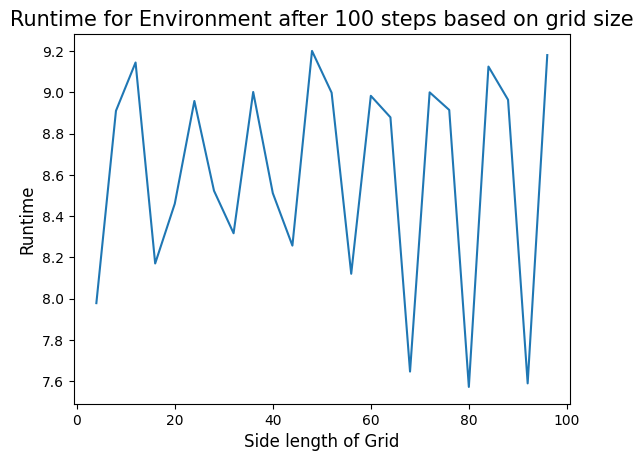

In [31]:

def get_model_runtime_cellsize(ns,steps):
  """ Time how long the model runs with increasing cell sizes (n) """
  xpoints = []
  ypoints = []

  for n in ns:
    xpoints.append(n)
    deers = Deer.make_deer(num_deer=10, n=n)
    model = Environment(n=n, deers=deers, p=0.3)
    ypoints.append(timeit(lambda: run_model_x_times(model,steps)))

  return xpoints,ypoints

def plot_gmrcs(ns,steps):
  """ Plot the runtimes for the get_model_runtime_cellsize function """
  xs,ys = get_model_runtime_cellsize(ns,steps)
  plt.plot(xs, ys)
  plt.xlabel("Side length of Grid", size=12)
  plt.ylabel("Runtime", size=12)
  plt.title(f"Runtime for Environment after {steps} steps based on grid size", size=15)

ns = range(4,100,4)
plot_gmrcs(ns,steps)

## Timing the model with **D** increasing.
So I expected the graph to be linear as the number of deer (***D***) increased with the number of steps (***S***) altering the slope.... but it would not do that. I can't figure out if its a code issue or my analysis is wrong but I've spent too long on this part in particular. Could you let me know where I went wrong if its not too much work?

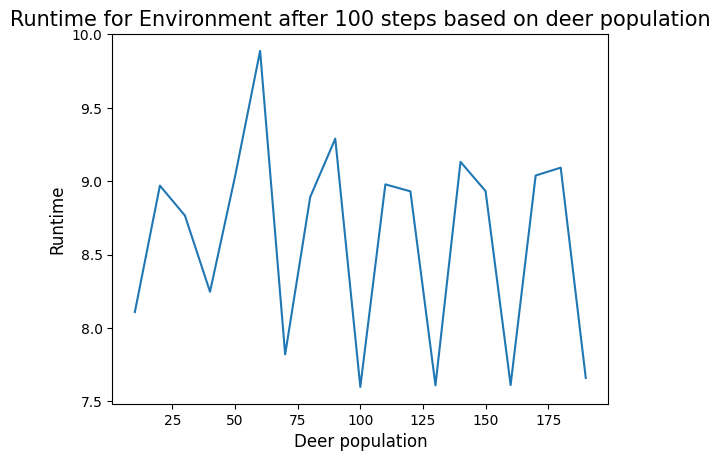

In [17]:
def get_model_runtime_deer_pop(num_deer,steps):
  """ Time how long the model runs when the number of deer (num_deer) are increased """
  xpoints = []
  ypoints = []
  n = 100

  for deer in num_deer:
    xpoints.append(deer)
    deers = Deer.make_deer(num_deer=deer, n=n)
    model = Environment(n=n, deers=deers, p=1) # p is 1 so that no deer die
    ypoints.append(timeit(lambda: run_model_x_times(model,steps)))

  return xpoints,ypoints

def plot_gmrdp(num_deer,steps):
  """ Plot the runtimes for the get_model_runtime_deer_pop function """
  xs,ys = get_model_runtime_deer_pop(num_deer,steps)
  plt.plot(xs, ys)
  plt.xlabel("Deer population", size=12)
  plt.ylabel("Runtime", size=12)
  plt.title(f"Runtime for Environment after {steps} steps based on deer population", size=15)

deers = range(10,200,10)
plot_gmrdp(deers,steps)